In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Setup paths
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data" / "raw"
PYBAMM_DIR = DATA_DIR / "final_pybamm_output"

# Expected configuration
TOTAL_SAMPLES = 100
PARAMS_PER_SAMPLE = 60
EXPECTED_TOTAL = TOTAL_SAMPLES * PARAMS_PER_SAMPLE

print("=" * 80)
print("🔍 PyBaMM Dataset Completeness Analysis")
print("=" * 80)
print(
    f"\nExpected: {TOTAL_SAMPLES} samples × {PARAMS_PER_SAMPLE} params = {EXPECTED_TOTAL} total"
)

🔍 PyBaMM Dataset Completeness Analysis

Expected: 100 samples × 60 params = 6000 total


In [2]:
sample_stats = []
missing_params_by_sample = {}

for sample_id in range(TOTAL_SAMPLES):
    parquet_file = PYBAMM_DIR / f"results_rank_{sample_id}.parquet"

    if not parquet_file.exists():
        sample_stats.append(
            {
                "sample_id": sample_id,
                "file_exists": False,
                "num_params": 0,
                "missing_params": PARAMS_PER_SAMPLE,
                "file_size_mb": 0,
            }
        )
        missing_params_by_sample[sample_id] = list(range(PARAMS_PER_SAMPLE))
        continue

    df = pd.read_parquet(parquet_file)

    if "param_id" in df.columns:
        param_ids = sorted(df["param_id"].unique())
        num_params = len(param_ids)

        expected_params = set(range(PARAMS_PER_SAMPLE))
        actual_params = set(param_ids)
        missing = sorted(expected_params - actual_params)

        if missing:
            missing_params_by_sample[sample_id] = missing
    else:
        num_params = len(df)
        param_ids = []
        missing = []

    sample_stats.append(
        {
            "sample_id": sample_id,
            "file_exists": True,
            "num_params": num_params,
            "missing_params": len(missing),
            "file_size_mb": parquet_file.stat().st_size / (1024 * 1024),
            "param_ids": param_ids,
        }
    )

df_stats = pd.DataFrame(sample_stats)
df_stats.head()

,sample_id,file_exists,num_params,missing_params,file_size_mb,param_ids
0,0,True,60,0,1.803042,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,1,True,60,0,1.751854,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,2,True,60,0,1.782999,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,3,True,60,0,1.879487,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,4,True,60,0,1.852081,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [3]:
print("\n" + "=" * 80)
print("📊 SUMMARY STATISTICS")
print("=" * 80)

total_found = df_stats["num_params"].sum()
total_missing = EXPECTED_TOTAL - total_found
missing_files = (~df_stats["file_exists"]).sum()

print("\nFile Statistics:")
print(f"   Files found: {df_stats['file_exists'].sum()}/{TOTAL_SAMPLES}")
print(f"   Files missing: {missing_files}")

print("\nParameter Statistics:")
print(f"   Total params found: {total_found}")
print(f"   Total params missing: {total_missing}")
print(f"   Completeness: {total_found / EXPECTED_TOTAL * 100:.2f}%")

print("\nParams per sample:")
print(f"   Min: {df_stats['num_params'].min()}")
print(f"   Max: {df_stats['num_params'].max()}")
print(f"   Mean: {df_stats['num_params'].mean():.2f}")
print(f"   Median: {df_stats['num_params'].median():.0f}")

incomplete_samples = df_stats[df_stats["num_params"] < PARAMS_PER_SAMPLE]

if len(incomplete_samples) > 0:
    print(f"\n⚠️  Incomplete Samples: {len(incomplete_samples)}")
    print(f"   Sample IDs: {sorted(incomplete_samples['sample_id'].tolist())[:20]}...")
else:
    print("\n✅ All samples are complete!")

print("\n" + "=" * 80)


📊 SUMMARY STATISTICS

File Statistics:
   Files found: 100/100
   Files missing: 0

Parameter Statistics:
   Total params found: 6000
   Total params missing: 0
   Completeness: 100.00%

Params per sample:
   Min: 60
   Max: 60
   Mean: 60.00
   Median: 60

✅ All samples are complete!



In [4]:
print("\n📋 DETAILED BREAKDOWN")
print("=" * 80)

param_counts = df_stats.groupby("num_params").size().sort_index()

print("\nDistribution of params per sample:")
print("-" * 40)
for num_params, count in param_counts.items():
    print(f"   {num_params:2d} params: {count:3d} samples")

print("\n" + "=" * 80)

zero_params = df_stats[df_stats["num_params"] == 0]
if len(zero_params) > 0:
    print(f"\n❌ Samples with 0 params ({len(zero_params)}):")
    print(f"   {sorted(zero_params['sample_id'].tolist())}")

partial_samples = df_stats[
    (df_stats["num_params"] > 0) & (df_stats["num_params"] < PARAMS_PER_SAMPLE)
]

if len(partial_samples) > 0:
    print(f"\n⚠️  Samples with partial data ({len(partial_samples)}):")
    for _, row in partial_samples.head(10).iterrows():
        print(
            f"   Sample {row['sample_id']:3d}: "
            f"{row['num_params']:2d}/{PARAMS_PER_SAMPLE} "
            f"params ({row['missing_params']} missing)"
        )

full_samples = df_stats[df_stats["num_params"] == PARAMS_PER_SAMPLE]
print(f"\n✅ Samples with complete data: {len(full_samples)}/{TOTAL_SAMPLES}")

print("\n" + "=" * 80)


📋 DETAILED BREAKDOWN

Distribution of params per sample:
----------------------------------------
   60 params: 100 samples


✅ Samples with complete data: 100/100



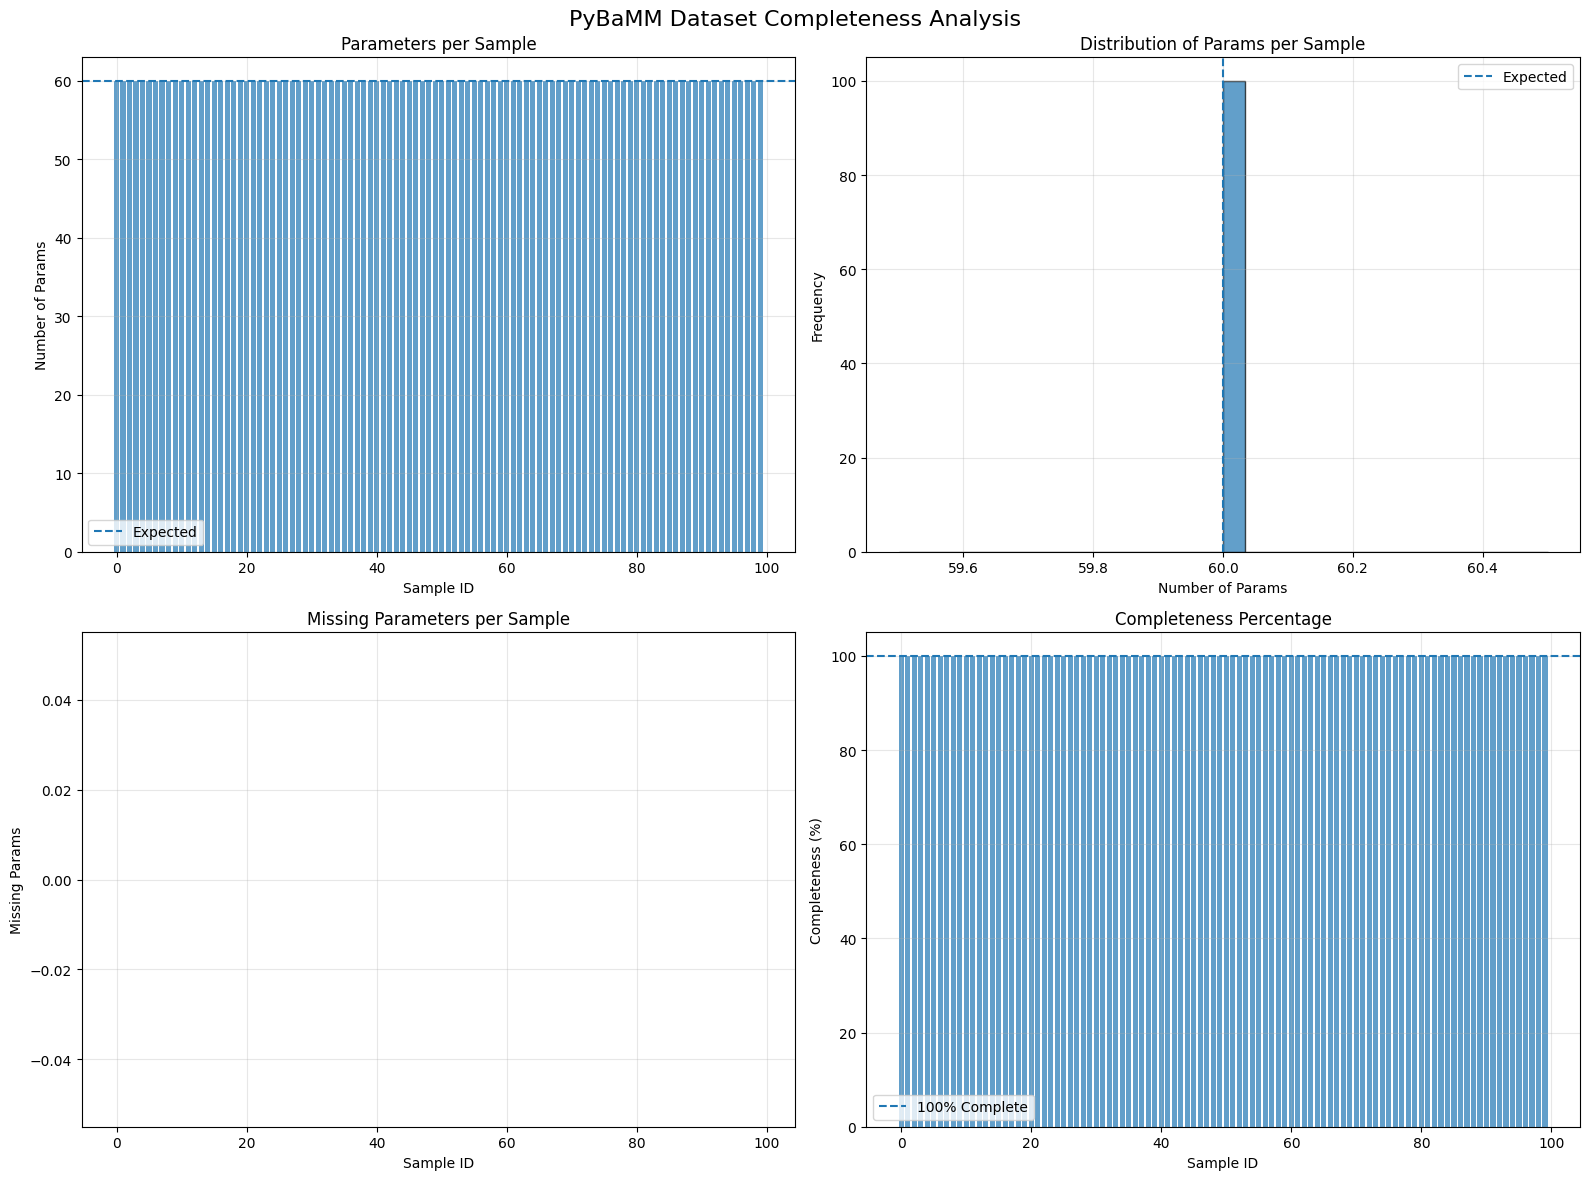


✅ Visualization complete


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]
ax1.bar(df_stats["sample_id"], df_stats["num_params"], alpha=0.7)
ax1.axhline(PARAMS_PER_SAMPLE, linestyle="--", label="Expected")
ax1.set_title("Parameters per Sample")
ax1.set_xlabel("Sample ID")
ax1.set_ylabel("Number of Params")
ax1.legend()
ax1.grid(alpha=0.3)

ax2 = axes[0, 1]
ax2.hist(df_stats["num_params"], bins=30, edgecolor="black", alpha=0.7)
ax2.axvline(PARAMS_PER_SAMPLE, linestyle="--", label="Expected")
ax2.set_title("Distribution of Params per Sample")
ax2.set_xlabel("Number of Params")
ax2.set_ylabel("Frequency")
ax2.legend()
ax2.grid(alpha=0.3)

ax3 = axes[1, 0]
ax3.bar(df_stats["sample_id"], df_stats["missing_params"], alpha=0.7)
ax3.set_title("Missing Parameters per Sample")
ax3.set_xlabel("Sample ID")
ax3.set_ylabel("Missing Params")
ax3.grid(alpha=0.3)

ax4 = axes[1, 1]
completeness = df_stats["num_params"] / PARAMS_PER_SAMPLE * 100
ax4.bar(df_stats["sample_id"], completeness, alpha=0.7)
ax4.axhline(100, linestyle="--", label="100% Complete")
ax4.set_ylim(0, 105)
ax4.set_title("Completeness Percentage")
ax4.set_xlabel("Sample ID")
ax4.set_ylabel("Completeness (%)")
ax4.legend()
ax4.grid(alpha=0.3)

plt.suptitle("PyBaMM Dataset Completeness Analysis", fontsize=16)
plt.tight_layout()
plt.show()

print("\n✅ Visualization complete")

In [6]:
if missing_params_by_sample:
    print("\n" + "=" * 80)
    print("🔍 MISSING PARAM_IDs BY SAMPLE")
    print("=" * 80)

    count = 0
    for sample_id, missing_params in sorted(missing_params_by_sample.items()):
        if count >= 20:
            print(f"\n... and {len(missing_params_by_sample) - 20} more samples")
            break

        print(f"\nSample {sample_id:3d}: {len(missing_params)} missing params")

        if len(missing_params) <= 10:
            print(f"   Missing: {missing_params}")
        else:
            ranges = []
            start = end = missing_params[0]

            for p in missing_params[1:]:
                if p == end + 1:
                    end = p
                else:
                    ranges.append(f"{start}" if start == end else f"{start}-{end}")
                    start = end = p

            ranges.append(f"{start}" if start == end else f"{start}-{end}")
            print(f"   Missing ranges: {', '.join(ranges)}")

        count += 1

    print("\n" + "=" * 80)
else:
    print("\n✅ No missing parameters found!")


✅ No missing parameters found!


In [7]:
if len(incomplete_samples) > 0:
    output_file = Path("..") / "data" / "incomplete_samples.csv"
    incomplete_samples[["sample_id", "num_params", "missing_params"]].to_csv(
        output_file, index=False
    )
    print(f"\n💾 Incomplete samples list saved to: {output_file}")

    report_file = Path("..") / "data" / "missing_params_report.txt"
    with open(report_file, "w") as f:
        f.write("=" * 80 + "\n")
        f.write("MISSING PARAMETERS REPORT\n")
        f.write("=" * 80 + "\n\n")
        f.write(f"Total samples: {TOTAL_SAMPLES}\n")
        f.write(f"Expected params per sample: {PARAMS_PER_SAMPLE}\n")
        f.write(f"Expected total: {EXPECTED_TOTAL}\n\n")
        f.write(f"Actual total found: {total_found}\n")
        f.write(f"Total missing: {total_missing}\n")
        f.write(f"Completeness: {total_found / EXPECTED_TOTAL * 100:.2f}%\n\n")

        for sample_id, missing in sorted(missing_params_by_sample.items()):
            f.write(f"Sample {sample_id:3d}: {len(missing)} missing\n")
            f.write(f"   Missing: {missing}\n\n")

    print(f"📄 Detailed report saved to: {report_file}")
else:
    print("\n✅ All samples complete - no report needed!")

print("\n" + "=" * 80)
print("✅ Analysis complete!")
print("=" * 80)


✅ All samples complete - no report needed!

✅ Analysis complete!
